In [1]:
#imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.coordinates import SkyCoord, ICRS
import astropy.units as u
%matplotlib inline

import popsims
from popsims.simulator import Population, pop_mags#, compute_vols_and_numbers, simulate_population
from popsims.galaxy import Disk, Halo
from popsims.core_tools import sample_from_powerlaw
from popsims.plot_style import  plot_style
#plt.style.use('fivethirtyeight')
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning) 

plot_style()

#plt.style.use('dark_background')

In [2]:
#roman deep field in the Fornax constellation
#https://hubblesite.org/contents/media/images/2021/003/01EX00FCXRZ7YVP4MPMAT1PW2X?news=true
#l=-27° 47' 29.04"
#03h 32m 38.99s
l= 2*np.pi*np.random.uniform(0, 1, 100)*u.radian
b= (np.arccos(2*np.random.uniform(0, 1, 100)-1)-np.pi/2)*u.radian

#coords=SkyCoord([SkyCoord(l="-27° 47' 29.04", b='03h 32m 38.99s', frame='galactic' ),
#          SkyCoord(l="-45° 47' 29.04", b='00h 32m 38.99s', frame='galactic' )]).transform_to(ICRS)

coords=SkyCoord(l=l, b=b, frame='galactic' ).transform_to(ICRS)

In [3]:
#compute magnitudes from distances
#assign roman magnitudes
roman_keys=['WFI_R062', 'WFI_Z087', 'WFI_Y106', 'WFI_J129', 'WFI_H158', 'WFI_F184', 'WFI_Prism', 'WFI_Grism']
jwst_keys=[ 'NIRISS_F115W']
euclid_keys=['EUCLID_Y', 'EUCLID_J', 'EUCLID_H']

all_keys=np.concatenate([roman_keys, jwst_keys, euclid_keys])

footprint = SkyCoord(l=np.random.uniform(-np.pi, np.pi, 10)*u.rad, 
                     b= np.random.uniform(-np.pi/2, np.pi/2, 10)*u.rad, frame='galactic' )

In [4]:
def compute_vols_and_numbers(df, gmodel, sptgrid, footprint, maglimits):
    from popsims.abs_mag_relations import POLYNOMIALS
    counts={}
    vols={}
    dists={}

    for spt in sptgrid:
        
        dmins=[]
        dmaxs=[]
        
        dmins_sd=[]
        dmaxs_sd=[]
        
        for k in maglimits.keys():
            mag_cut= maglimits[k]
            absmag= np.poly1d(POLYNOMIALS['absmags_spt']['dwarfs'][k]['fit'])(spt)
            
            #absmag_sd= np.poly1d(POLYNOMIALS['absmags_spt']['subdwarfs'][k]['fit'])(spt)
        
            mag_cut= maglimits[k]
            
            dmin=10.**(-(absmag-mag_cut[0])/5. + 1.)
            dmax=10.**(-(absmag-mag_cut[1])/5. + 1.)
            
            #dmin_sd=10.**(-(absmag_sd-14)/5. + 1.)
            #dmax_sd=10.**(-(absmag_sd-mag_cut)/5. + 1.)
        
            
            dmins.append(dmin)
            dmaxs.append(dmax)
            
            #dmins_sd.append(dmin)
            #dmaxs_sd.append(dmax)
            
        dmin=np.nanmedian(dmins)
        dmax=np.nanmedian(dmaxs)
        
        #dmin_sd=np.nanmedian(dmins_sd)
        #dmax_sd=np.nanmedian(dmaxs_sd)
        
        #print (spt, dmin, dmax)
        
        scale=[df.scale.mean(), df.scale_unc.mean(), df.scale_times_model.mean()]
        
        sn= len(df)
        #sn= len(df.query('population == "thin disk"'))
        #snt= len(df.query('population == "thick disk"'))
        #snh= len(df.query('population == "halo"'))
      
        sn_c= len(df.query('spt < {}'.format(spt, spt+0.9)))
        #snt_c= len(df.query('population == "thick disk" and spt >= {} and spt < {}'.format(spt, spt+0.9)))
        #snh_c= len(df.query('population == "halo" and spt >= {} and spt < {}'.format(spt, spt+0.9)))
        
        
        volumes={'volume': 0.0}
        
        cnts={'number':  sn_c*np.divide(scale[-1], sn)}
        for s in  footprint:
            l=s.galactic.l.radian
            b=s.galactic.b.radian
            volumes['volume'] += gmodel.volume(l, b, dmin, dmax)/len(footprint)
            #volumes['thick'] += tdisk.volume(l, b, dmin, dmax)/len(footprint)
            #volumes['halo'] += halo.volume(l, b, dmin, dmax)/len(footprint)
            
        vols.update({spt: volumes})
        counts.update({spt: cnts})
        dists.update({spt: dmax})
        
        
    return pd.DataFrame.from_records(vols).T.replace(np.inf, np.nan),\
    pd.DataFrame.from_records(counts).T.replace(np.inf, np.nan),\
    dists


In [5]:
#kirkpatrick
p1=Population(evolmodel= 'burrows1997',
              imf_power=-0.6,
              binary_fraction=0.2,
              age_range=[8, 14],
              mass_range=[0.01, .1],
             nsample=1e6)
    
p1.simulate()

p1.add_distances(Halo(), footprint.l.radian,footprint.b.radian, 0.1,  50_000, dsteps=5000)

#add magnitudes from pre-defined filters or pre-define polynomial cofficients
p1.add_magnitudes(jwst_keys, get_from='spt',object_type='dwarfs')

In [6]:
#kirkpatrick
p2=Population(evolmodel= 'burrows1997',
              imf_power=0,
              binary_fraction=0.2,
              age_range=[8, 14],
              mass_range=[0.01, .1],
             nsample=1e6)
    
p2.simulate()
p2.add_distances(Halo(), footprint.l.radian,footprint.b.radian, 0.1,  50_000, dsteps=5000)

#add magnitudes from pre-defined filters or pre-define polynomial cofficients
p2.add_magnitudes(jwst_keys, get_from='spt',object_type='dwarfs')

In [98]:
#kirkpatrick
p3=Population(evolmodel= 'burrows1997',
              imf_power=-2.35,
              binary_fraction=0.2,
              age_range=[8, 14],
              mass_range=[0.01, .1],
             nsample=1e6)
    
p3.simulate()

p3.add_distances(Halo(), footprint.l.radian,footprint.b.radian, 0.1,  50_000, dsteps=5000)

#add magnitudes from pre-defined filters or pre-define polynomial cofficients
p3.add_magnitudes(jwst_keys, get_from='spt',object_type='dwarfs')

In [99]:
cols=['spt', 'abs_NIRISS_F115W','NIRISS_F115W', 'scale','scale_unc','scale_times_model','l','b','distance']

In [100]:
df2=p2.to_dataframe(cols)
df1=p1.to_dataframe(cols)
df3=p3.to_dataframe(cols)

In [101]:
maglimits={'NIRISS_F115W': [10, 27.]}
sptgrid=np.arange(20, 40)

In [102]:
n2=compute_vols_and_numbers(df2, Halo(), sptgrid, footprint, maglimits)
n1=compute_vols_and_numbers(df1, Halo(), sptgrid, footprint, maglimits)
n3=compute_vols_and_numbers(df3, Halo(), sptgrid, footprint, maglimits)

In [106]:
areas=(np.arange(1, 1000)*u.arcmin**2).to(u.radian**2)
counts1=np.nansum(np.array([n1[1].number.loc[x]*n1[0].volume.loc[x]*areas.value for x in sptgrid]), axis=0)/400
counts2=np.nansum(np.array([n2[1].number.loc[x]*n2[0].volume.loc[x]*areas.value for x in sptgrid]), axis=0)/400
counts3=np.nansum(np.array([n3[1].number.loc[x]*n3[0].volume.loc[x]*areas.value for x in sptgrid]), axis=0)/400

In [113]:
surveys={'PASSAGES': (124*4*u.arcmin**2).to(u.degree**2).value,
        'JADES': (200*u.arcmin**2).to(u.degree**2).value,
        'CEERS':(10*4*u.arcmin**2).to(u.degree**2).value,
        #'GLASS':(18*u.arcmin**2).to(u.degree**2).value}
        }

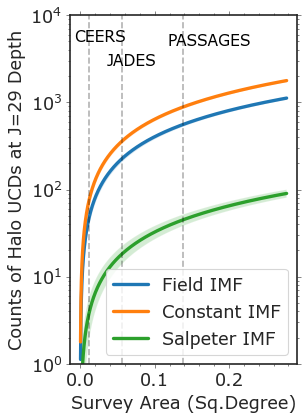

In [151]:
fig, ax=plt.subplots(figsize=(6*0.7, 8*0.7))
ax.plot(areas.to(u.degree**2).value, counts1, linewidth=3,  label='Field IMF')
ax.fill_between(areas.to(u.degree**2).value, counts1-counts1**0.5, counts1+counts1**0.5, alpha=0.2)

ax.plot(areas.to(u.degree**2).value, counts2, linewidth=3, label='Constant IMF')
ax.fill_between(areas.to(u.degree**2).value, counts2-counts2**0.5, counts2+counts2**0.5, alpha=0.2)

ax.plot(areas.to(u.degree**2).value, counts3, linewidth=3, label='Salpeter IMF')
ax.fill_between(areas.to(u.degree**2).value, counts3-counts3**0.5, counts3+counts3**0.5, alpha=0.2)

for k in surveys.keys():
    ax.axvline(surveys[k], linestyle='--', color='k', alpha=0.3)
    ax.text(surveys[k]-0.02, 5e3-np.random.uniform(0, 5e3*0.6), k ,c='k', fontsize=14)
ax.minorticks_on()
ax.legend()
ax.set(yscale='log', xlabel='Survey Area (Sq.Degree)', ylabel='Counts of Halo UCDs at J=29 Depth', 
      ylim=[1, 1e4])
plt.tight_layout()
plt.savefig('../figures/jwst_preds_imfs.pdf')

In [10]:
jjh

NameError: name 'jjh' is not defined

In [ ]:
#draw masses from a power-law IMF and uniform ages
#define a galaxy density model and draw distances in a given direction
disk= Disk(H=300, L=2600)
tdisk=Disk(H=900, L=3600)
halo= Halo()

df0=simulate_full_pop(-1, 10,50_000, all_keys, nsample=1e6)
df1=simulate_full_pop(-0.5, 10,50_000, all_keys, nsample=1e6)
df2=simulate_full_pop(0, 10,50_000, all_keys, nsample=1e6)

In [ ]:
sptgrid=np.arange(15, 40)
maglimits_roman={'WFI_J129': [10, 26.2]}
maglimits_jwst={'NIRISS_F115W': [10, 27]}
maglimits_euclid={'NIRISS_F115W': [10, 27]}
maglimits_lss={''}

In [ ]:
def compute_numbers(df0, cuts):
    query=''
    for k in cuts.keys():
        query += k+'<='+str(cuts[k][1])
    
    print (query)
    df= df0.query(query).reset_index(drop=True)
    ns= compute_vols_and_numbers(df, disk, tdisk, halo, sptgrid,coords, cuts)
    return ns

In [ ]:
ns_roman0= compute_numbers(df0, maglimits_roman)
ns_roman1=compute_numbers(df1, maglimits_roman)
ns_roman2=compute_numbers(df2, maglimits_roman)

In [ ]:
ns_jwst0= compute_numbers(df0, maglimits_jwst)
ns_jwst1=compute_numbers(df1, maglimits_jwst)
ns_jwst2=compute_numbers(df2, maglimits_jwst)

In [ ]:
ns_euc0= compute_numbers(df0, maglimits_euclid)
ns_euc1=compute_numbers(df1, maglimits_euclid)
ns_euc2=compute_numbers(df2, maglimits_euclid)

In [ ]:
AREA_JWST=124*(4*(u.arcmin**2)).to(u.radian**2)
AREA_ROMAN=(2_000*(u.degree**2)).to(u.radian**2)

In [ ]:
fig, ax=plt.subplots(figsize=(7, 7),sharey=True)

ax.step(ns_roman1[0].index, ns_roman1[0].thin*ns_roman1[1].thin*AREA_ROMAN,\
        color='#FFFFFF',  linestyle='-', label='Thin Disk', linewidth=3)

ax.step(ns_roman1[0].index, 0.12*ns_roman1[0].thick*ns_roman1[1].thick*AREA_ROMAN,\
         color='#FFFFFF',  linestyle='dashed', label='Thick Disk',  linewidth=3)

ax.step(ns_roman1[0].index, (1/400)*ns_roman1[0].halo*ns_roman1[1].halo*AREA_ROMAN,\
           color='#FFFFFF', linestyle='dotted', label='Halo',  linewidth=3)

ax.set(yscale='log', ylabel=r'Number Counts', xlabel='Spectral Type', \
       xticks=[17, 20, 30, 40], xticklabels=['M7', 'L0', 'T0', 'Y0'])

ax.minorticks_on()

ax.legend(fontsize=12)

In [ ]:
fig, ax=plt.subplots(figsize=(6, 7),sharey=True)

ax.step(ns_jwst1[0].index, ns_jwst1[0].thin*ns_roman1[1].thin*AREA_JWST,\
        color='#7FDBFF',  linestyle='-', label='Thin Disk', linewidth=3)

ax.step(ns_jwst1[0].index, 0.12*ns_jwst1[0].thick*ns_jwst1[1].thick*AREA_JWST,\
         color='#01FF70',  linestyle='dashed', label='Thick Disk',  linewidth=3)

ax.step(ns_jwst1[0].index, (1/400)*ns_jwst1[0].halo*ns_jwst1[1].halo*AREA_JWST,\
           color='#FF851B', linestyle='dotted', label='Halo',  linewidth=3)

ax.set(yscale='log', ylabel=r'Number Counts', xlabel='Spectral Type', \
       xticks=[17, 20, 30, 40], xticklabels=['M7', 'L0', 'T0', 'Y0'])

ax.minorticks_on()

ax.legend(fontsize=12)
plt.savefig('/users/caganze/jwst_preds.pdf')

In [ ]:
np.nansum(ns_jwst1[0].halo*ns_roman1[1].halo*AREA_JWST.value)/400

In [ ]:
ns_jwst1[0].halo*ns_roman1[1].halo*AREA_JWST.value

In [ ]:
0.149*124*4

In [ ]:
124*(4*(u.arcmin**2))

In [ ]:
662.95+175

In [ ]:
import itertools
import astropy.units as u
import numpy as np
ds=[770, 1000]
bws=[0.1, 0.7]


In [ ]:
iterables

In [ ]:
def fx(x, y):
    return x>y

In [ ]:
fx(*iterables[0])

In [ ]:
from concurrent.futures import ThreadPoolExecutor, wait , ALL_COMPLETED
from  functools import partial

iterables=list(np.array([(x, y) for x, y in np.array(list(itertools.product(ds, bws)))]).T)
method=partial(fx)
with ThreadPoolExecutor(max_workers=10) as executor:
    futures=list(executor.map( method, *iterables, timeout=None, chunksize=10))


In [ ]:
[x for x in futures]